In [2]:

import matplotlib.pyplot as plt
import numpy as np
import json
import tqdm
from pathlib import Path

In [28]:
import requests, zipfile, io, re

# find all links that ends with .zip
def find_zip_links(url):
    page = requests.get(url).text
    links = re.findall(r'href=[\'"]?([^\'" >]+)', page)
    return [url + link for link in links if link.endswith('.zip')]

# extract all files from zip file in https://www.geoapify.com/data-share/localities/
def extract_zip_files(url):
    r = requests.get(url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall("data/cities")
    
# print(find_zip_links('https://www.geoapify.com/data-share/localities/'))
for link in tqdm.tqdm(find_zip_links('https://www.geoapify.com/data-share/localities/')):
    extract_zip_files(link)

In [6]:
# Extract all the data from the .ndjson files.
# Took ~3-4 minutes on my machine (only villages)
def load_ndjson(file):
    data = []
    with open(file) as f:
        for line in f:
            data.append(json.loads(line))
    return data

def extract_data(exclude):
    DATA_PATH = Path("data/cities/")
    CITY_TYPES = ["hamlet", "town", "village", "city"]

    data = []
    data_paths = list(Path(DATA_PATH).rglob("*.ndjson"))

    for i, file_name in enumerate(tqdm.tqdm(data_paths, total=len(data_paths))):
        if any([e in file_name.stem for e in exclude]):
            continue
        
        if i > 400:
            break
        data += load_ndjson(file_name)
        
    return data

exclude = ["hamlet", "town", "city"]
data = extract_data(exclude)

 49%|████▊     | 401/823 [00:36<00:38, 11.10it/s]


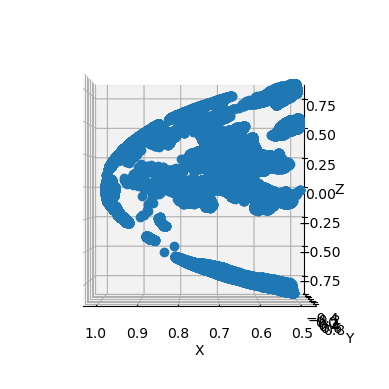

In [13]:
# convert longitude and latitude to x, y, and z
def from_latlon(latlon):
    lat = np.deg2rad(latlon[...,0])
    lon = np.deg2rad(latlon[...,1])
    x = np.cos(lat) * np.cos(lon)
    y = np.cos(lat) * np.sin(lon)
    z = np.sin(lat)
    return x, y, z

latlon = np.array([d['location'] for d in data])
x,y,z = from_latlon(latlon)

# remove all data points with negative x values
mask = x > 0.5
x = x[mask]
y = y[mask]
z = z[mask]

plt.figure()
ax = plt.axes(projection='3d')

ax.set_box_aspect([1,1,1])

# give the axes labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# change the view
ax.view_init(0, 0)
plt.plot(x, y, z, 'o')
plt.show()
# print(len(from_latlon(np.array(latlon))[0]))